In [21]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import wasserstein_distance

from epuc.helpers.ensemble import Ensemble
from epuc.helpers.distance_analysis import (
    compute_wasserstein_distance,
    ecdf_values_ensemble,
    parametric_cdf_values_beta,
)
from epuc.configs import create_train_config

### Load individual models from Ensemble, as well as Second Order Predictor model:

In [2]:
save_path_classification = "../data/classification/new_simulation/exp_1"
save_path_regression = "../data/regression/new_simulation/exp_1"
config_path_classification = "../data/classification/new_simulation/exp_1/params.json"
config_path_regression = "../data/regression/new_simulation/exp_1/params.json"

# load configs from path 
with open(config_path_classification, "r") as f:
    config_class_temp = json.load(f)
with open(config_path_regression, "r") as f:
    config_reg_temp = json.load(f)

config_classification = create_train_config(
    type="classification",
    lambda_reg = config_class_temp["lambda_reg"],
    ensemble_size=config_class_temp["ensemble_size"],
    ensemble_size_secondary=config_class_temp["ensemble_size_secondary"],
    hidden_dim=config_class_temp["hidden_dim"],
    n_hidden_layers=config_class_temp["n_hidden_layers"],
    
)


In [24]:
# matplotlib parameters
plt.rcParams['image.cmap'] = 'viridis'
# latex as text renderer
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 18,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)
viridis = matplotlib.colormaps['viridis']

### Do distance analysis for classification case:

In [29]:
# initialize models of first oerder ensemble, and second order models
ensemble_primary = Ensemble(model_config=config_classification["Bernoulli"]["model_config"], ensemble_size=config_classification["Bernoulli"]["ensemble_size"])
ensemble_secondary_inner = Ensemble(model_config=config_classification["Beta_inner"]["model_config"], ensemble_size=config_classification["Beta_inner"]["ensemble_size"])
ensemble_model_outer = Ensemble(model_config=config_classification["Beta_outer"]["model_config"], ensemble_size=config_classification["Beta_outer"]["ensemble_size"])
ensemble_secondary_inner_reg = Ensemble(model_config=config_classification["Beta_inner_reg"]["model_config"], ensemble_size=config_classification["Beta_inner_reg"]["ensemble_size"])
ensemble_model_outer_reg = Ensemble(model_config=config_classification["Beta_outer_reg"]["model_config"], ensemble_size=config_classification["Beta_outer_reg"]["ensemble_size"])

In [32]:
ensemble_primary.load_models(save_path_classification + "/Bernoulli")
ensemble_secondary_inner.load_models(save_path_classification + "/Beta_inner")
ensemble_model_outer.load_models(save_path_classification + "/Beta_outer")
#ensemble_secondary_inner_reg.load_models(save_path_classification + "/Beta_inner_reg")
ensemble_model_outer_reg.load_models(save_path_classification + "/Beta_outer_reg")

In [33]:
theta_values = np.linspace(0, 1, 10000)
x_values = np.linspace(0, 1, 100)
x_test = np.array([0]).reshape(-1,1)
models_ens = ensemble_primary.models
model_inner_secondary = ensemble_secondary_inner.models[0] # take first ensemble member as example
# compute wasserstein distance for each x
wasserstein_values_inner = compute_wasserstein_distance(ens_models=models_ens,
                                                   second_order_model=model_inner_secondary,
                                                  x_values=x_values, theta_interval=(0,1), n_splits=1000)
wasserstein_values_outer = compute_wasserstein_distance(ens_models=models_ens,
                                                    second_order_model=ensemble_model_outer.models[0],
                                                      x_values=x_values, theta_interval=(0,1), n_splits=1000)
wasserstein_values_outer_reg = compute_wasserstein_distance(ens_models=models_ens,
                                                    second_order_model=ensemble_model_outer_reg.models[0],
                                                      x_values=x_values, theta_interval=(0,1), n_splits=1000)

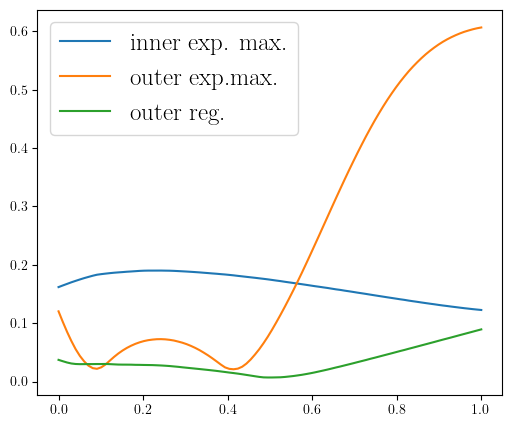

In [34]:
# use viridis color map

# make plot as scatter plot with crosses connected
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(x_values, wasserstein_values_inner, label="inner exp. max.")
plt.plot(x_values, wasserstein_values_outer, label="outer exp.max.")
plt.plot(x_values, wasserstein_values_outer_reg, label="outer reg.")
plt.legend()
